<h1>Содержание<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Подготовка" data-toc-modified-id="Подготовка-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Подготовка</a></span></li><li><span><a href="#Анализ" data-toc-modified-id="Анализ-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Анализ</a></span></li><li><span><a href="#Обучение" data-toc-modified-id="Обучение-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Обучение</a></span></li><li><span><a href="#Тестирование" data-toc-modified-id="Тестирование-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Тестирование</a></span></li><li><span><a href="#Вывод" data-toc-modified-id="Вывод-5"><span class="toc-item-num">5&nbsp;&nbsp;</span>Вывод</a></span></li><li><span><a href="#Чек-лист-проверки" data-toc-modified-id="Чек-лист-проверки-6"><span class="toc-item-num">6&nbsp;&nbsp;</span>Чек-лист проверки</a></span></li></ul></div>

#  Прогнозирование заказов такси

Компания «Чётенькое такси» собрала исторические данные о заказах такси в аэропортах. Чтобы привлекать больше водителей в период пиковой нагрузки, нужно спрогнозировать количество заказов такси на следующий час. Постройте модель для такого предсказания.

Значение метрики *RMSE* на тестовой выборке должно быть не больше 48.

Вам нужно:

1. Загрузить данные и выполнить их ресемплирование по одному часу.
2. Проанализировать данные.
3. Обучить разные модели с различными гиперпараметрами. Сделать тестовую выборку размером 10% от исходных данных.
4. Проверить данные на тестовой выборке и сделать выводы.


Данные лежат в файле `taxi.csv`. Количество заказов находится в столбце `num_orders` (от англ. *number of orders*, «число заказов»).

## Подготовка

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split, cross_val_score, TimeSeriesSplit, GridSearchCV
from sklearn.linear_model import LinearRegression, Ridge
from catboost import CatBoostRegressor
from lightgbm import LGBMRegressor
from statsmodels.tsa.seasonal import seasonal_decompose
import warnings
warnings.filterwarnings('ignore')

Сначала я импортировала данные обычным способом и проверила на наличие пропусков; убедившись, что их нет, переписала загрузку файла с конвертацией столбца времени в индексы.

In [2]:
try:
    data = pd.read_csv('taxi.csv', index_col=[0], parse_dates=[0])
except:
    data = pd.read_csv('/datasets/taxi.csv', index_col=[0], parse_dates=[0])

In [3]:
data.head(10)

,num_orders
datetime,
2018-03-01 00:00:00,9
2018-03-01 00:10:00,14
2018-03-01 00:20:00,28
2018-03-01 00:30:00,20
2018-03-01 00:40:00,32
2018-03-01 00:50:00,21
2018-03-01 01:00:00,7
2018-03-01 01:10:00,5
2018-03-01 01:20:00,17


Данные идут с шагом в 10 минут. Проверяем порядок времени по индексам.

In [4]:
display(data.index.is_monotonic)
data.info()

True

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 26496 entries, 2018-03-01 00:00:00 to 2018-08-31 23:50:00
Data columns (total 1 columns):
 #   Column      Non-Null Count  Dtype
---  ------      --------------  -----
 0   num_orders  26496 non-null  int64
dtypes: int64(1)
memory usage: 414.0 KB


Индексы расположены по порядку, пропусков нет, тип данных верен. Приступаем к анализу.

## Анализ

Находим границы диапазона данных.

In [5]:
print('Начало данных:', data.index.min())
print('Конец данных:', data.index.max())

Начало данных: 2018-03-01 00:00:00
Конец данных: 2018-08-31 23:50:00


Поскольку 10 минут - слишком малый шаг, выполняем ресемплирование до 1 часа.

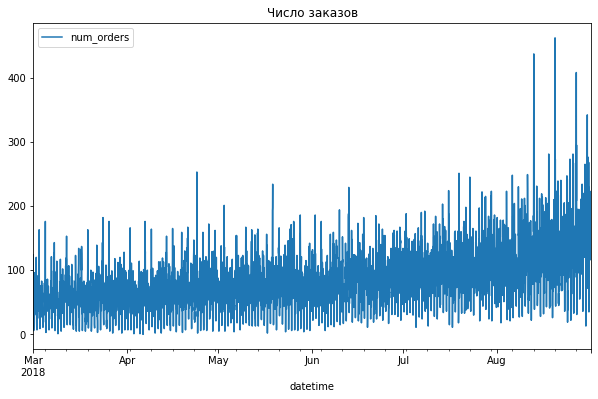

In [6]:
data = data.resample('1H').sum()
data.plot(figsize=(10,6), title='Число заказов');

Судить по этому графику о том, как идут дела у сервиса, сложно - он слишком неровный, хотя просматривается тренд к повышению. Ресемплируем до недели:

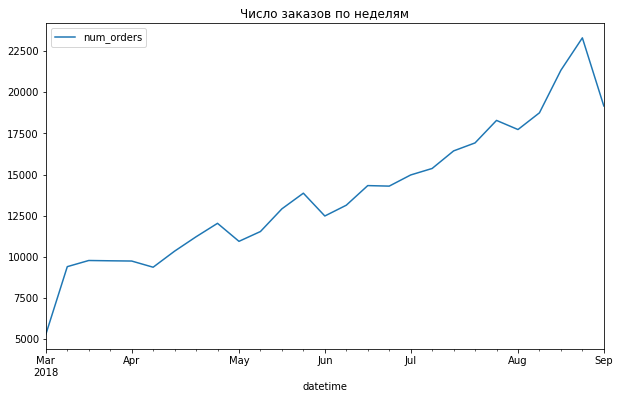

In [7]:
data_week = data.resample('1W').sum()
data_week.plot(figsize=(10,6), title='Число заказов по неделям');

Теперь можно сказать, что сервис успешен - число заказов растёт от месяца к месяцу. Однако, однозначного решения принять нельзя, т.к. данные есть лишь за полгода - возможно, просто попался "удачный" период. С помощью функции `seasonal_decompose()` разложим временной ряд на три составляющие: тренд, сезонность и остаток.

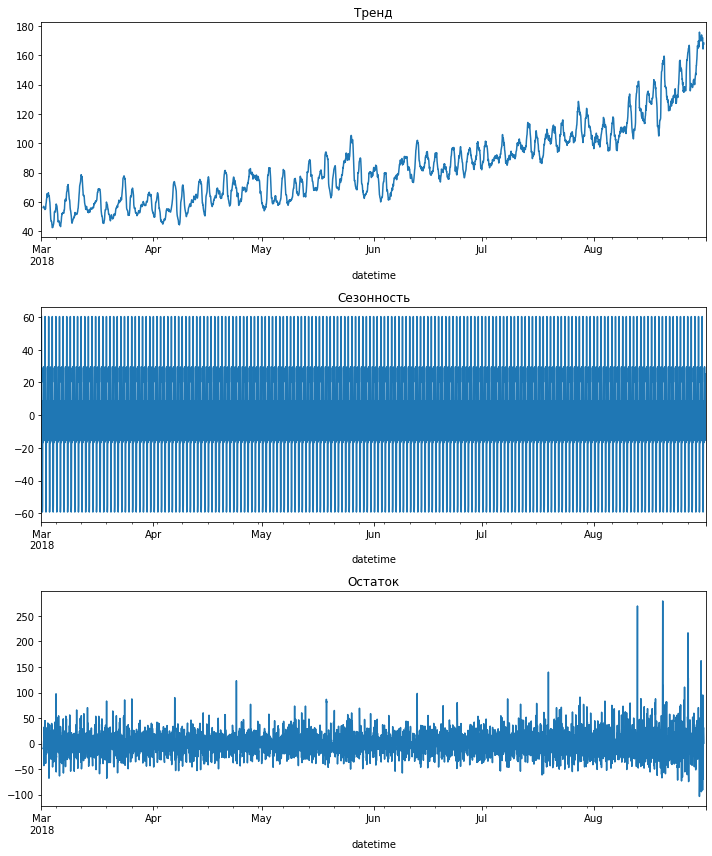

In [8]:
decomposed = seasonal_decompose(data['num_orders'], model='additive')

plt.figure(figsize=(10, 12))
plt.subplot(311)
decomposed.trend.plot(ax=plt.gca())
plt.title('Тренд')
plt.subplot(312)
decomposed.seasonal.plot(ax=plt.gca())
plt.title('Сезонность')
plt.subplot(313)
decomposed.resid.plot(ax=plt.gca())
plt.title('Остаток')
plt.tight_layout()

Тренд растёт от месяца к месяцу, теперь изучим сезонность, для чего ресемплируем данные по одному дню.

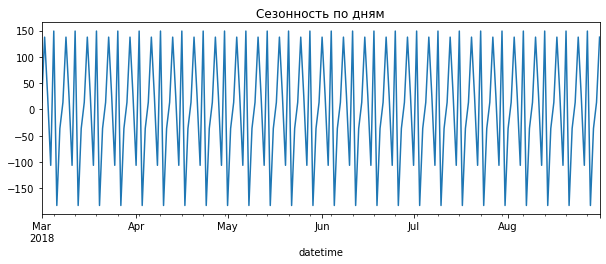

In [9]:
data_day = data.resample('1D').sum()

decomposed_day = seasonal_decompose(data_day['num_orders'], model='additive')

plt.figure(figsize=(10, 12))
plt.subplot(311)
decomposed_day.seasonal.plot(ax=plt.gca())
plt.title('Сезонность по дням');

Здесь заметны колебания раз в неделю - на выходных услугами такси пользуются реже.

Теперь найдём разности временного ряда.

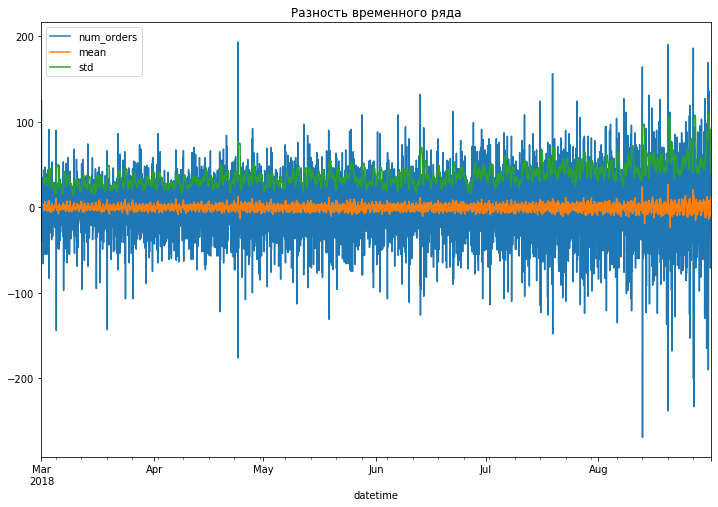

In [10]:
data_shifted = data - data.shift(fill_value=0)
data_shifted['mean'] = data_shifted['num_orders'].rolling(15).mean()
data_shifted['std'] = data_shifted['num_orders'].rolling(15).std()
data_shifted.plot(figsize=(12,8), title='Разность временного ряда');

После применения метода `.shift()` ряд стал более стационарным, а значит, его можно спрогнозировать.

In [11]:
from statsmodels.tsa.stattools import adfuller

ts = data['num_orders']
st_test = adfuller(ts, regression='ctt')

print('Если значение с индексом 1 меньше P-Value, заданное нами (обычно берут 0.05), то ряд стационарный')
if st_test[1] < 0.05:
    print('Наш ряд стационарный')
else:
    print('Ряд нестационарный')



Если значение с индексом 1 меньше P-Value, заданное нами (обычно берут 0.05), то ряд стационарный
Наш ряд стационарный


## Обучение

Нам понадобятся признаки:
* час - есть суточная сезонность
* день
* день недели - т.к. к концу недели и в середине идёт увеличение заказов

Поскольку год на протяжении всего набора данных один, он не влияет на результат и его можно не включать в признаки.

In [12]:
# функция для создания признаков
def make_features(data, max_lag, rolling_mean_size):
    data['hour'] = data.index.hour
    data['day'] = data.index.day
    data['dayofweek'] = data.index.dayofweek
    
    for lag in range(1, max_lag + 1):
        data['lag_{}'.format(lag)] = data['num_orders'].shift(lag)

    data['rolling_mean'] = data['num_orders'].shift().rolling(rolling_mean_size).mean()

~~Для определения lag найдём разницу в часах между максимальным пиком ночью и минимальным пиком в сезонном сегменте.~~
Для ширины окна rolling_mean проверим, какое окно в скользящем среднем лучше всего напоминает данные, для чего заполним словарь разными значениями rolling_mean_size и RMSE между скользящим средним и реальными данными на отрезке 30-31 августа (сутки у конца диапазона данных). После этого по минимальному значению RMSE в словаре найдём необходимое rolling_mean_size.

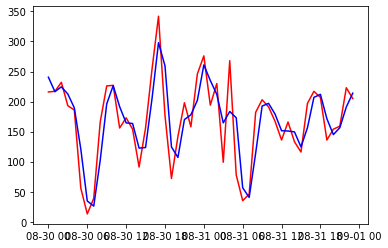

36.98915944796079


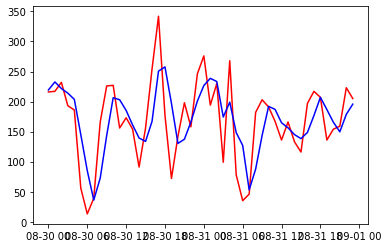

52.219666013088585


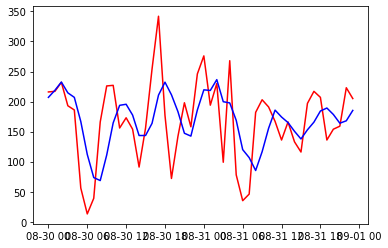

61.73457339354775


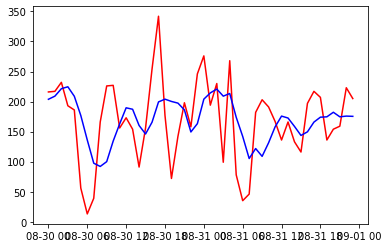

64.93109809636674


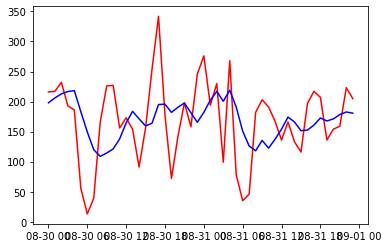

66.37807327055457


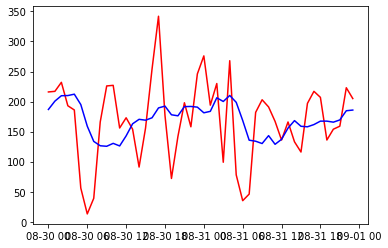

67.03321848868947


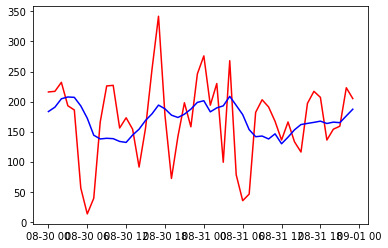

66.07711325287549


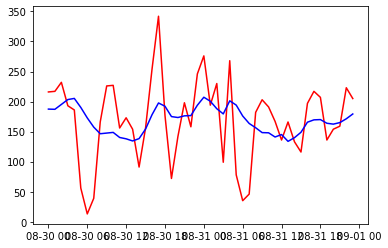

64.82589257184684


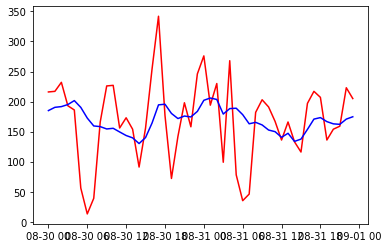

64.8972794113898


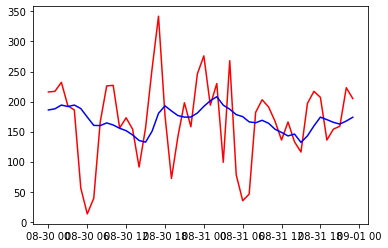

66.46865911561704


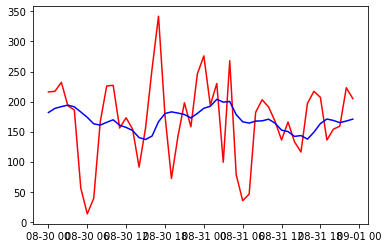

67.08032688225087


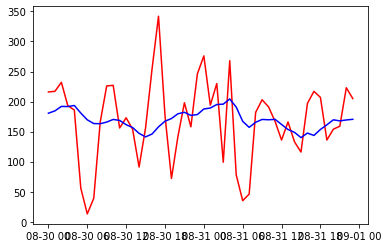

67.15206458558447


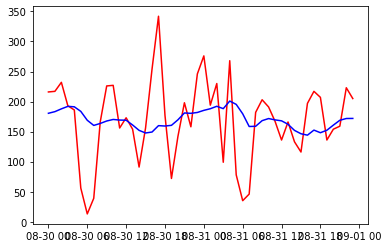

67.19811555909791


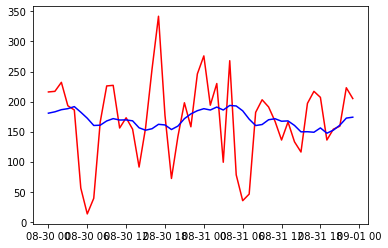

67.40505462418149


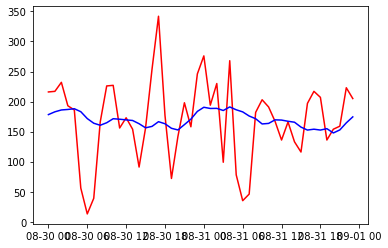

67.64638351844835


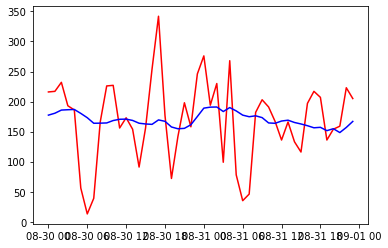

67.30413935385982


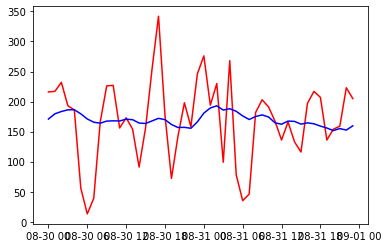

67.25874906755021


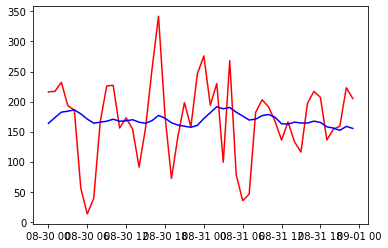

67.40076021022296


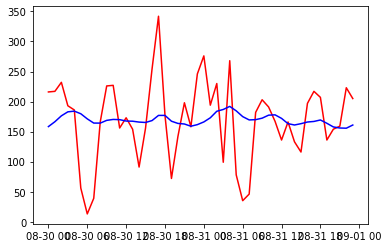

68.06754113562499


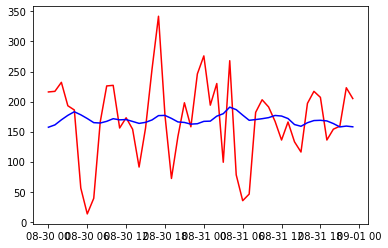

68.50024517062238


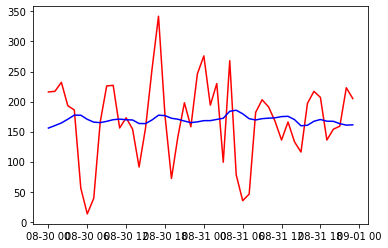

68.86388763830544


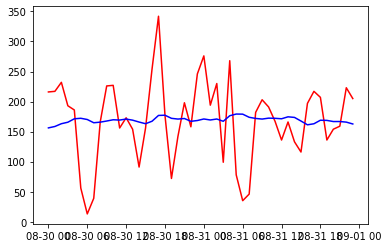

68.69392540482477


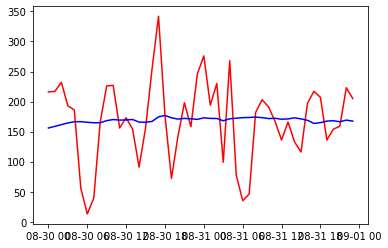

67.9081346890374


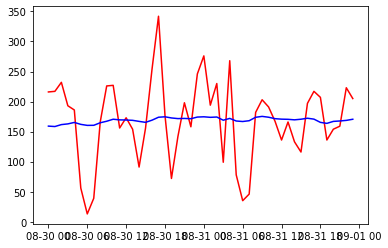

66.24640266962929


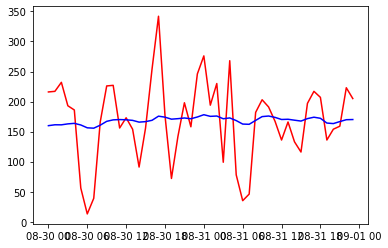

64.94040067471789


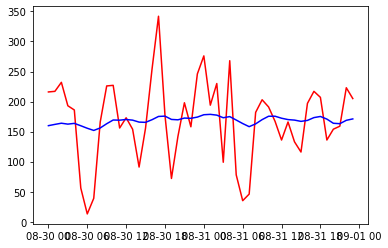

64.74053592079926


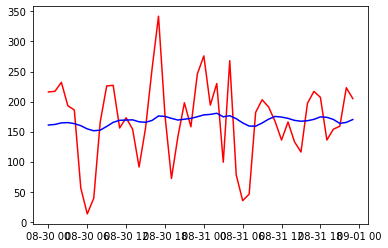

65.29951027126212


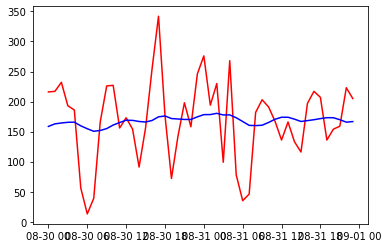

65.92793240429907


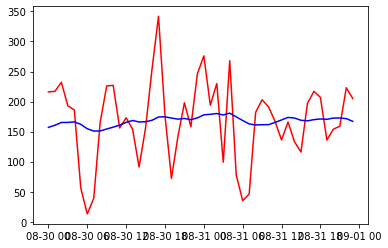

66.22491051823435


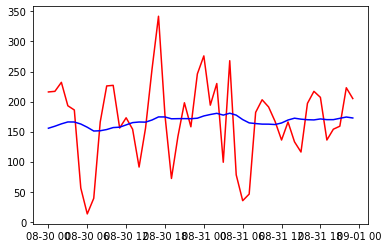

66.52620011521017


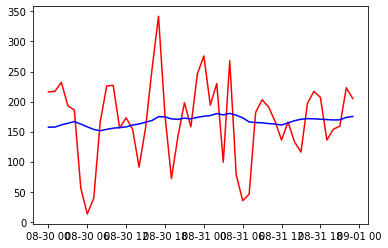

66.63293875417945


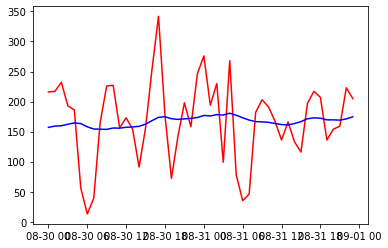

66.6363426787166


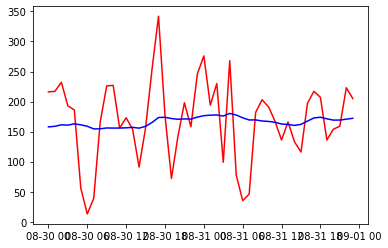

66.51722048759717


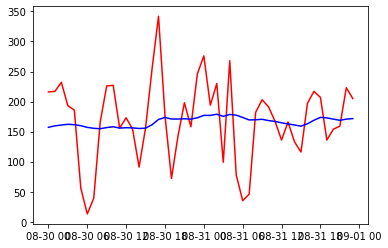

66.71273871460174


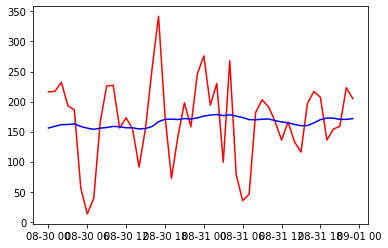

67.04084841995426


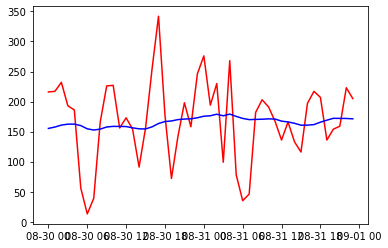

67.09860894970288


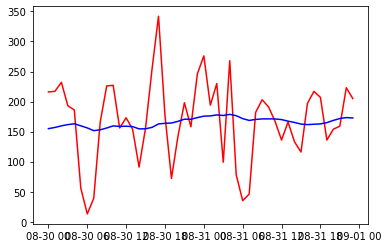

67.13110549015683


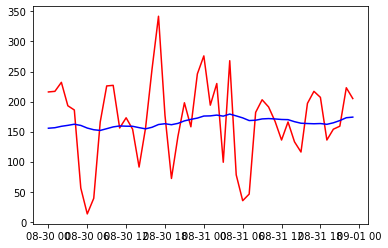

67.251912886346


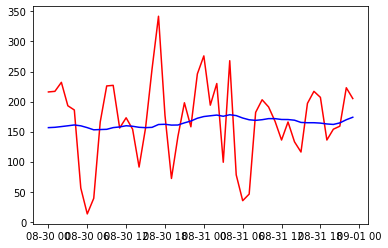

67.45894034753658


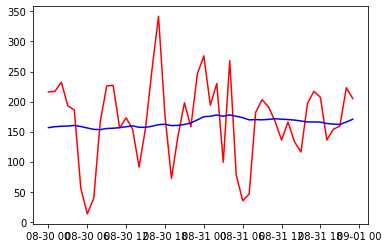

67.52952439254788


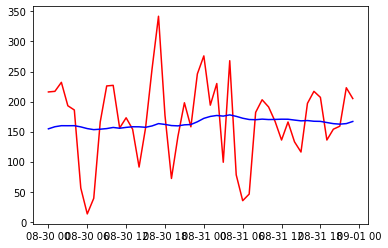

67.55013946081354


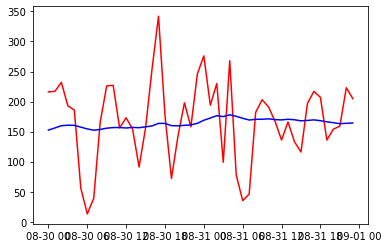

67.59716647500687


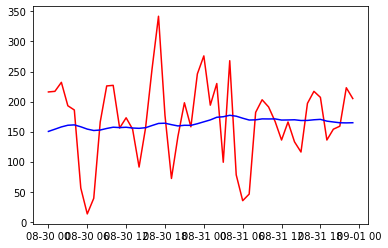

67.87760764412928


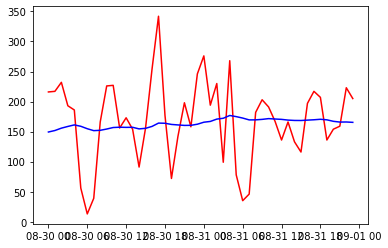

68.1627530646305


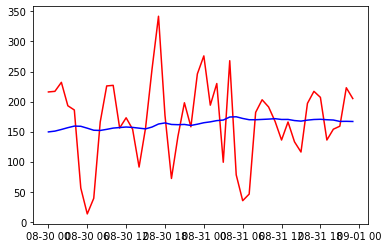

68.49865566432516


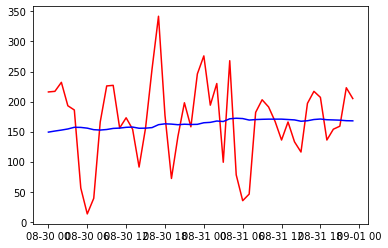

68.62075921700615


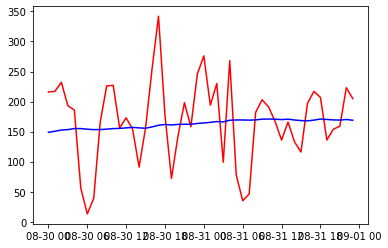

68.38335432597269


In [14]:
rolling_mean_size_dict = {}
for rolling_mean_size in range(2,49):
    data_copy = data['2018-08-30':'2018-08-31'].copy()
    data_copy['rolling_mean'] = data['num_orders'].rolling(rolling_mean_size).mean()
    data_copy.dropna(inplace=True)
    index = data_copy.index
    num_orders = data_copy['num_orders']
    rolling_mean = data_copy['rolling_mean']
    plt.plot(index,num_orders,'r-',index, rolling_mean,'b-')
    plt.show()
    RMSE = mean_squared_error(num_orders, rolling_mean)**0.5
    print(RMSE)
    rolling_mean_size_dict[rolling_mean_size] = RMSE

In [15]:
rolling_mean_size = min(rolling_mean_size_dict.keys(), key=(lambda x: rolling_mean_size_dict[x]))
rolling_mean_size

2

В функции для создания признаков будем использовать полученную переменную для rolling_mean_size и значение 24 для числа лагов.

In [16]:
make_features(data, 24, rolling_mean_size)
data.head()

,num_orders,hour,day,dayofweek,lag_1,lag_2,lag_3,lag_4,lag_5,lag_6,...,lag_16,lag_17,lag_18,lag_19,lag_20,lag_21,lag_22,lag_23,lag_24,rolling_mean
datetime,,,,,,,,,,,,,,,,,,,,,
2018-03-01 00:00:00,124,0,1,3,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-03-01 01:00:00,85,1,1,3,124.0,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-03-01 02:00:00,71,2,1,3,85.0,124.0,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,104.5
2018-03-01 03:00:00,66,3,1,3,71.0,85.0,124.0,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,78.0
2018-03-01 04:00:00,43,4,1,3,66.0,71.0,85.0,124.0,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,68.5


Функция `train_test_split` по умолчанию перемешивает данные, что нам в данном случае не нужно, поэтому добавим параметр `shuffle=False`.

После применения функции `make_features` у нас появились NaN-значения за счет сдвига данных. Их никак не заполнить, остаётся только удалить.

In [18]:
train, test = train_test_split(data, shuffle=False, test_size=0.1)
train = train.dropna()

features_train = train.drop(['num_orders'], axis=1)
target_train = train['num_orders']

features_test = test.drop(['num_orders'], axis=1)
target_test = test['num_orders']

Проверка, что данные не перемешались:

In [19]:
print(features_train.index[features_train.shape[0]-1])
print(features_test.index[0])

2018-08-13 13:00:00
2018-08-13 14:00:00


Порядок данных сохранён, что обязательно для предсказания временных рядов.

Находим iterations и depth для модели CatBoost.

In [26]:
cat_model = CatBoostRegressor(loss_function='RMSE')

params_search = [{'depth' : [1, 3, 5, 7, 9, 11],
                'learning_rate' : [0.1, 0.2, 0.3],
                'iterations' : [50, 75, 100, 125, 150],
                'verbose': [10]
               }]

tscv = TimeSeriesSplit(n_splits=5)
gsearch = GridSearchCV(estimator=cat_model, cv=tscv, param_grid=params_search)
gsearch.fit(features_train, target_train)

catbr = GridSearchCV(cat_model, params_search, cv=tscv, scoring='neg_root_mean_squared_error')
catbr.fit(features_train, target_train)

print(catbr.best_score_)
print(catbr.best_params_)

Custom logger is already specified. Specify more than one logger at same time is not thread safe.

0:	learn: 28.9561621	total: 387us	remaining: 19ms
10:	learn: 24.2011801	total: 3.3ms	remaining: 11.7ms
20:	learn: 21.8530968	total: 5.99ms	remaining: 8.27ms
30:	learn: 20.6280944	total: 8.74ms	remaining: 5.36ms
40:	learn: 19.9894748	total: 11.4ms	remaining: 2.51ms
49:	learn: 19.5598913	total: 13.8ms	remaining: 0us
0:	learn: 29.5396072	total: 506us	remaining: 24.8ms
10:	learn: 25.2565824	total: 4.43ms	remaining: 15.7ms
20:	learn: 23.1509878	total: 8.2ms	remaining: 11.3ms
30:	learn: 22.0045469	total: 12ms	remaining: 7.34ms
40:	learn: 21.3422116	total: 15.7ms	remaining: 3.46ms
49:	learn: 20.9510590	total: 19ms	remaining: 0us
0:	learn: 31.1714795	total: 631us	remaining: 31ms
10:	learn: 26.5616568	total: 5.43ms	remaining: 19.3ms
20:	learn: 24.2786344	total: 10.3ms	remaining: 14.2ms
30:	learn: 23.0008927	total: 15.2ms	remaining: 9.33ms
40:	learn: 22.2644656	total: 20.4ms	remaining: 4.49ms
49:	learn: 21.8852864	total: 24.6ms	remaining: 0us
0:	learn: 32.5038352	total: 665us	remaining: 32.6ms
1

## Тестирование

Объединяем все предсказания в список и сравниваем его элементы с тестовой выборкой через написанную функцию RMSE.

In [27]:
def rmse (target, predictions):
    mse = mean_squared_error(target, predictions)
    rmse = mse ** 0.5
    return rmse

In [28]:
# функция для построения моделей и их обучения; для CatBoost используем параметры, найденные кросс-валидацией
def make_models(features, target, test):
    lin_model = LinearRegression()
    lin_model.fit(features, target)
    predicted_lin = lin_model.predict(features_test)
    
    ridge_model = Ridge()
    ridge_model.fit(features, target)
    predicted_ridge = ridge_model.predict(features_test)
    
    lgbm_params = {
        'boosting_type': 'gbdt',
        'objective': 'regression',
        'metric': 'rmse',
        'max_depth': 6, 
        'learning_rate': 0.1,
        'verbose': 0
    }
    
    lgbm_model = LGBMRegressor(**lgbm_params)
    lgbm_model.fit(features_train, target_train)
    predicted_lgbm = lgbm_model.predict(features_test)
    
    cat_params = {'depth': 7, 'iterations': 150, 'learning_rate': 0.1, 'verbose': 10}
    cat_model = CatBoostRegressor(**cat_params)
    cat_model.fit(features_train, target_train)
    predicted_cat = cat_model.predict(features_test)
    
    return predicted_lin, predicted_ridge, predicted_lgbm, predicted_cat

In [30]:
predicted_lin, predicted_ridge, predicted_lgbm, predicted_cat = make_models(features_train, target_train, features_test)

[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.204405 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positi

In [31]:
results = [predicted_lin, predicted_ridge, predicted_lgbm, predicted_cat]

for result in results:
    print(rmse(target_test, result))
    print('---')

45.168592970102175
---
45.16858906704581
---
41.03410465944701
---
42.8341668141025
---


## Вывод

Лучший результат показала LightGBM, хоть она и с параметрами по умолчанию. CatBoost на втором месте, а линейные модели теперь практически идентичны и отстают от обеих моделей градиентного бустинга. Как прототип для сервиса такси можно посоветовать LightGBM.

## Чек-лист проверки

- [x]  Jupyter Notebook открыт
- [x]  Весь код выполняется без ошибок
- [x]  Ячейки с кодом расположены в порядке исполнения
- [x]  Данные загружены и подготовлены
- [x]  Данные проанализированы
- [x]  Модель обучена, гиперпараметры подобраны
- [x]  Качество моделей проверено, выводы сделаны
- [x]  Значение *RMSE* на тестовой выборке не больше 48